<a href="https://colab.research.google.com/github/ShikhaVishwakarma/Data-Science-Projects/blob/main/timeseriesLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas_datareader as pdr

In [ ]:
!pip install yfinance
import yfinance as yf
data = yf.download('^BSESN', start = '2016-10-10', end='2021-10-10')
data

     |████████████████████████████████| 6.3 MB 6.3 MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.63-py2.py3-none-any.whl size=23918 sha256=7eab0aafb02e6c50133f1a2091b606bae02a10fcd1fcdb817600dddb376530a2
  Stored in directory: /root/.cache/pip/wheels/fe/87/8b/7ec24486e001d3926537f5f7801f57a74d181be25b11157983
Successfully built yfinance
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-10-10,28144.279297,28216.640625,28068.320312,28082.339844,28082.339844,6900
2016-10-13,28042.619141,28042.619141,27563.839844,27643.109375,27643.109375,11900
2016-10-14,27712.220703,27763.539062,27548.179688,27673.599609,27673.599609,14000
2016-10-17,27776.140625,27803.210938,27488.300781,27529.970703,27529.970703,17100
2016-10-18,27656.890625,28064.390625,27652.759766,28050.880859,28050.880859,16200
...,...,...,...,...,...,...
2021-10-04,59143.000000,59548.820312,58952.109375,59299.320312,59299.320312,10000
2021-10-05,59320.140625,59778.871094,59127.039062,59744.878906,59744.878906,12900
2021-10-06,59942.000000,59963.570312,59079.859375,59189.730469,59189.730469,7000


In [ ]:
print(data.columns)

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')


In [ ]:
data=data.reset_index()['Close']
data

0       28082.339844
1       27643.109375
2       27673.599609
3       27529.970703
4       28050.880859
            ...     
1224    59299.320312
1225    59744.878906
1226    59189.730469
1227    59677.828125
1228    60059.058594
Name: Close, Length: 1229, dtype: float64

Text(0, 0.5, 'Close price')

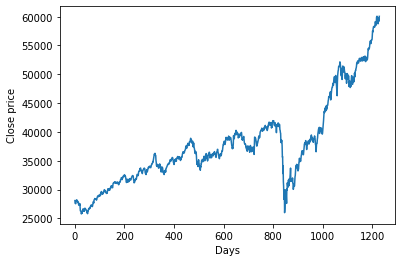

In [ ]:
import matplotlib.pyplot as plt
plt.plot(data)
plt.xlabel('Days')
plt.ylabel('Close price')

In [ ]:
#LSTM is sensitive to scale of the data
import numpy as np
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
data=scaler.fit_transform(np.array(data).reshape(-1,1))
print(data)

[[0.06753175]
 [0.05473095]
 [0.05561955]
 ...
 [0.97411607]
 [0.98834104]
 [0.99945151]]


In [ ]:
training_size=int(len(data)*0.75)
test_size=len(data)-training_size
train_data,test_data=data[0:training_size,:],data[training_size:len(data),:1]


In [ ]:
training_size,test_size

(921, 308)

In [ ]:
#convert an array of values into a dataset matrix
def create_dataset(dataset,time_step):
  dataX,dataY=[],[]
  for i in range(len(dataset)-time_step-1):    #i=0   0,1,2,3...99(x_train)   100(y_train)  if time_step=100  
    a = dataset[i:(i+time_step),0]
    dataX.append(a)
    dataY.append(dataset[i+time_step,0])
  return np.array(dataX),np.array(dataY)




In [ ]:
#reshape into X=t,t+1,t+2,t+3,...t+99 and Y=t+100
time_step=100
X_train,y_train=create_dataset(train_data,time_step)
X_test,y_test=create_dataset(test_data,time_step)



In [ ]:
X_train.shape,y_train.shape

((820, 100), (820,))

In [ ]:
X_test.shape,y_test.shape

((207, 100), (207,))

In [ ]:
#reshape dim of input from 2d to 3d as required for lstm[sample,time_step,features]
X_train=X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test=X_test.reshape(X_test.shape[0],X_test.shape[1],1)



In [ ]:
X_train.shape,X_test.shape

((820, 100, 1), (207, 100, 1))

In [ ]:
#create the stacked lstm model(more than one hidden layer)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM


In [ ]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 50)           10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=41,verbose=1)

Epoch 1/100
20/20 [==============================] - 8s 203ms/step - loss: 0.0153 - val_loss: 0.0541
Epoch 2/100
20/20 [==============================] - 3s 137ms/step - loss: 0.0030 - val_loss: 0.0348
Epoch 3/100
20/20 [==============================] - 3s 135ms/step - loss: 0.0019 - val_loss: 0.0131
Epoch 4/100
20/20 [==============================] - 3s 135ms/step - loss: 0.0015 - val_loss: 0.0051
Epoch 5/100
20/20 [==============================] - 3s 138ms/step - loss: 0.0014 - val_loss: 0.0092
Epoch 6/100
20/20 [==============================] - 3s 135ms/step - loss: 0.0013 - val_loss: 0.0049
Epoch 7/100
20/20 [==============================] - 3s 135ms/step - loss: 0.0012 - val_loss: 0.0027
Epoch 8/100
20/20 [==============================] - 3s 135ms/step - loss: 0.0012 - val_loss: 0.0038
Epoch 9/100
20/20 [==============================] - 3s 136ms/step - loss: 9.8899e-04 - val_loss: 0.0016
Epoch 10/100
20/20 [==============================] - 3s 137ms/step - loss: 0.0011 - va

In [ ]:
#Lets do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [ ]:
#Transforming back to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [ ]:
#Calculating RMSE performance metric
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

35399.685418370376

In [ ]:
math.sqrt(mean_squared_error(y_test,test_predict))

54111.883912912715

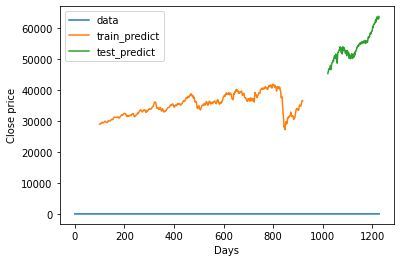

In [ ]:
#Plotting
#Shift train predictions for plotting
look_back=100
trainPredictPlot=np.empty_like(data)
trainPredictPlot[:,:]=np.nan
trainPredictPlot[look_back:len(train_predict)+look_back,:]=train_predict
#shift test predictions for plotting
testPredictPlot=np.empty_like(data)
testPredictPlot[:,:]=np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(data)-1,:]=test_predict
#Plot baseline and predictions
plt.plot(data)
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.xlabel('Days')
plt.ylabel('Close price')
plt.legend(['data','train_predict','test_predict'])
plt.show()

In [ ]:
len(test_data)

308

In [36]:
x_input1=test_data[208:].reshape(-1,1)
x_input=x_input1.T
x_input.shape

(1, 100)

In [37]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [38]:
len(temp_input)

100

In [39]:
import tensorflow as tf

In [41]:
#demonstrate prediction for next 30 days
from numpy import array
lst_output=[]
n_steps=100
i=0
while (i<10):
  if (len(temp_input)>100):
    #temp_input
    x_input=np.array(temp_input[1:])
    print("{} day input {}".format(i,x_input))
    x_input=x_input.reshape(-1,1)
    x_input=x_input.reshape((1,n_steps,1))
    #print x_input
    x_input=tf.convert_to_tensor(x_input)
    yhat=model.predict(x_input,verbose=0)
    print("{} day output {}".format(i,yhat))
    temp_input.extend(yhat[0].tolist())
    temp_input=temp_input[1:]
    #print temp_input
    lst_output.extend(yhat.tolist())
    i=i+1
  else:
    x_input=x_input.reshape((1,n_steps,1))
    x_input=tf.convert_to_tensor(x_input)
    yhat=model.predict(x_input,verbose=0)
    print(yhat[0])
    temp_input.extend(yhat[0].tolist())
    print(len(temp_input))
    lst_output.extend(yhat.tolist())
    i=i+1
print(lst_output)

0 day input [0.77864874 0.77386598 0.77870589 0.79022721 0.78967871 0.79532041
 0.78116181 0.7758358  0.77544236 0.78701355 0.79092814 0.79835397
 0.79780628 0.78070883 0.77036612 0.78898018 0.7930192  0.78941904
 0.78144801 0.77751213 0.78361364 0.78168344 0.7922856  0.81772019
 0.8336446  0.83723132 0.8309619  0.83460873 0.83903299 0.83819568
 0.84746486 0.86475606 0.86899032 0.8751015  0.87035746 0.86160945
 0.86820959 0.87996008 0.87952964 0.87967217 0.8847903  0.90708648
 0.92639794 0.92015595 0.93514537 0.94323013 0.94809599 0.94758802
 0.94673648 0.94833381 0.94462356 0.94664404 0.96051963 0.97270055
 0.96904974 0.95375044 0.9687402  0.9664687  0.99438927 0.99914288
 1.         0.988043   0.98063083 0.9722692  0.96175471 0.97730993
 0.99029515 0.97411607 0.98834104 0.99945151 1.11772776 1.22808969
 1.30096376 1.34422088 1.37463892 1.40443444 1.43830168 1.47592318
 1.5153482  1.55502391 1.59429121 1.63306749 1.67141771 1.7093333
 1.74670243 1.78336191 1.81913948 1.85388017 1.8874

In [42]:
day_new=np.arange(1,101)
day_pred=np.arange(101,111)


In [32]:
import matplotlib.pyplot as plt


In [43]:
len(data)

1229

In [45]:
df=data.tolist()
df.extend(lst_output)


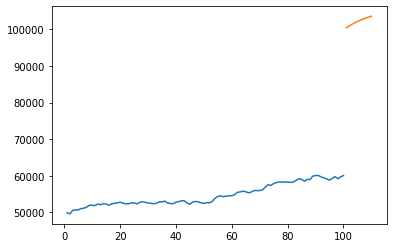

In [48]:
plt.plot(day_new,scaler.inverse_transform(data[1129:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))
#plt.xlabel('Days')
#plt.ylabel('Close price')
#plt.legend(['day_new','day_pred(future 30 days)'])
#plt.show()

Text(0, 0.5, 'Close price')

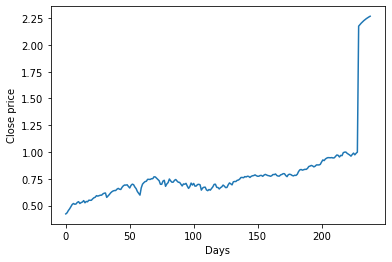

In [50]:

plt.plot(df[1000:])
plt.xlabel('Days')
plt.ylabel('Close price')

In [ ]:
#to improve this model, instead of 100 try using 150 timesteps or forecast 100 days into the future.

In [49]:
#close price of 10 days in future
day_pred

array([101, 102, 103, 104, 105, 106, 107, 108, 109, 110])